# 시작 코드

## Install

In [ ]:
!git clone https://github.com/roboflow-ai/Monk_Object_Detection.git
!cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
!pip install efficientnet_pytorch
!pip install tensorboardX

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3747, done.
remote: Total 3747 (delta 0), reused 0 (delta 0), pack-reused 3747
Receiving objects: 100% (3747/3747), 132.20 MiB | 27.34 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Checking out files: 100% (4032/4032), done.
     |████████████████████████████████| 352.6 MB 9.8 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-py3-none-any.whl size=17463 sha256=59f12820d0ac305522abbec5d9298192aba320c4ddfcb3dcc4b2661c0b98885d
  Stored in directory: /root/.cache/pip/wheels/18/44/5a/c7b93703f611ae3b50820efbaf265413e6b183a56cbec6f661
Successfully built dicttoxml
  Cloning https://github.com/abhi-kumar/cocoapi.git to /tmp/pip-install-3x7n9pnw/pycocotools_b31c2e3925e548a8a89a5cd05ed51476
  Running command git clone -q https://github.com/abhi-kuma

## 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq '/content/drive/MyDrive/Detection_of_lesions/data.zip' -d '/content'

In [ ]:
!mkdir Lesions
!mkdir Lesions/annotations
!mkdir Lesions/Images

## Labelme 형식에서 COCO 형식으로 변환

In [ ]:
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
IMG_SIZE = 512

def convert_to_coco(
    root_path: os.PathLike, 
    save_path: os.PathLike
) -> None:
    """
        only for train dataset
    """
    res = defaultdct(list)i
    json_paths = glob(os.path.join(root_path, 'train', '*.json'))
    
    categories = {
        '01_ulcer': 1,
        '02_mass': 2,
        '04_lymph': 3,
        '05_bleeding': 4
    }
    
    n_id = 0
    for json_path in tqdm(json_paths):
        with open(json_path, 'r') as f:
            tmp = json.load(f)
            
        image_id = int(tmp['file_name'].split('_')[-1][:6])
        res['images'].append({
            'id': image_id,
            'width': tmp['imageWidth'],
            'height': tmp['imageHeight'],
            'file_name': tmp['file_name'],
        })
        
        for shape in tmp['shapes']:
            box = np.array(shape['points'])
            x1, y1, x2, y2 = \
                min(box[:, 0]), min(box[:, 1]), max(box[:, 0]), max(box[:, 1])
            
            w, h = x2 - x1, y2 - y1
            
            res['annotations'].append({
                'id': n_id,
                'image_id': image_id,
                'category_id': categories[shape['label']],
                'area': w * h,
                'bbox': [x1, y1, w, h],
                'iscrowd': 0,
            })
            n_id += 1
    
    for name, id in categories.items():
        res['categories'].append({
            'id': id,
            'name': name,
        })
        
    with open(save_path, 'w') as f:
        json.dump(res, f)

In [ ]:
def get_colors(classes: List) -> Dict[str, tuple]:
    return {c: tuple(map(int, np.random.randint(0, 255, 3))) for c in classes}


def draw_bbox(
    json_path: os.PathLike,
    coco_path: os.PathLike, 
    save_path: os.PathLike,
    n_images: int = 62622,
) -> None:
    '''
        visualization based on COCO format annotation
    '''
    with open(coco_path, 'r') as f:
        ann_json = json.load(f)
        
    images = [{v['id']: v['file_name']} for v in ann_json['images']]
    categories = {v['id']: v['name'] for v in ann_json['categories']}
    
    ann = defaultdict(list)
    for a in ann_json['annotations']:
        bbox = list(map(round, a['bbox']))
        ann[a['image_id']].append(
            {
                'category_id': categories.get(a['category_id']),
                'bbox': bbox,
            }
        )
        
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    else:
        shutil.rmtree(save_path)
        os.makedirs(save_path)
        
    colors = get_colors(categories.values())
    for v in tqdm(images[:n_images]):
        image_id, file_name = list(v.items())[0]
        file_path = os.path.join(json_path, file_name)
        with open(file_path, 'r') as f:
            json_file = json.load(f)
            
        image = np.frombuffer(base64.b64decode(json_file['imageData']), np.uint8)
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        annots = ann[image_id]
        
        for a in annots:
            label = a['category_id']
            x1, y1, w, h = a['bbox']
            x2, y2 = x1 + w, y1 + h
            
            cv2.rectangle(image, (x1, y1), (x2, y2), colors[label], 2)
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX, 0.6, 1)
            cv2.rectangle(image, (x1, y1-20), (x1+tw, y1), colors[label], -1)
            cv2.putText(image, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        file_name = file_name.split('.')[0] + '.jpg'
        cv2.imwrite(os.path.join(save_path, file_name), image)

In [ ]:
convert_to_coco('.', '/content/Lesions/train_annotations.json')
draw_bbox('./train/', '/content/Lesions/train_annotations.json', '/content/Lesions/Images')

100%|██████████| 62622/62622 [08:39<00:00, 120.49it/s]


In [ ]:
with open('/content/Lesions/train_annotations.json') as f:
  data = json.load(f)
for i in range(62622):
  data['images'][i]['file_name'] = data['images'][i]['file_name'].replace('json','jpg')

save_file = open('/content/Lesions/annotations/instances_Images.json','w')
json.dump(data, save_file)
save_file.close()

# 훈련

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [ ]:
from train_detector import Detector

In [ ]:
gtf = Detector();

In [ ]:
#directs the model towards file structure
root_dir = "/content";
coco_dir = 'Lesions'; # 코코 파일형식으로 저장되어 있는 폴더
img_dir = "./";
set_dir = "Images"; # 코코 파일형식으로 저장되어 있는 폴더 중 이미지 폴더

In [ ]:
#smells like some free compute from Colab, nice
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=512, use_gpu=True)

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [ ]:
gtf.Model();

Loaded pretrained weights for efficientnet-b0


In [ ]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

In [ ]:
%%time
gtf.Train(num_epochs=1, model_output_dir="trained/");

Monk_Object_Detection/4_efficientdet/lib/src/model.py:251: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  if len(inputs) == 2:
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might caus

CPU times: user 1h 26min 43s, sys: 22min 32s, total: 1h 49min 15s
Wall time: 1h 32min 17s


# Inference

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [ ]:
from infer_detector import Infer

In [ ]:
gtf = Infer();

In [ ]:
#our trained model weights are in here in onxx format
# gtf.Model(model_dir="/content/drive/MyDrive/Detection_of_lesions/result/efficientdet_trained/") # epoch 5 짜리 모델
gtf.Model(model_dir="/content/trained") # 지금 훈련시킨 모델

In [ ]:
#extract class list from our annotations
import json
with open('/content/Lesions/annotations/instances_Images.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [ ]:
class_list

['01_ulcer', '02_mass', '04_lymph', '05_bleeding']

## Test 파일 변환

In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

import torch
import torchvision
import torch.distributed as dist
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from collections import defaultdict, deque

import seaborn as sns
from pathlib import Path
import scipy 
from joblib import Parallel , delayed

In [ ]:

base_path = Path('/content')
test_path = list((base_path / 'test').glob('test*'))
test_files = sorted(glob('/content/test/*'))

if len(test_files) == 20874:
  print('데이터를 정상적으로 불러왔습니다.')
else:
  print('데이터 길이에 문제가 있습니다.')

데이터 길이에 문제가 있습니다.


In [ ]:
label_info = pd.read_csv((base_path /'class_id_info.csv'))
categories = {i[0]:i[1]-1 for i in label_info.to_numpy()}
label_info

,class,class_id
0,01_ulcer,1
1,02_mass,2
2,04_lymph,3
3,05_bleeding,4


In [ ]:
def xyxy2coco(xyxy):
    x1,y1,x2,y2 =xyxy
    w,h =  x2-x1, y2-y1
    return [x1,y1,w,h] 

def xyxy2yolo(xyxy):
    
    x1,y1,x2,y2 =xyxy
    w,h =  x2-x1, y2-y1
    xc = x1 + int(np.round(w/2)) # xmin + width/2
    yc = y1 + int(np.round(h/2)) # ymin + height/2
    return [xc/IMG_SIZE,yc/IMG_SIZE,w/IMG_SIZE,h/IMG_SIZE] 

def scale_bbox(img, xyxy):
    # Get scaling factor
    scale_x = IMG_SIZE/img.shape[1]
    scale_y = IMG_SIZE/img.shape[0]
    
    x1,y1,x2,y2 =xyxy
    x1 = int(np.round(x1*scale_x,4))
    y1 = int(np.round(y1*scale_y, 4))
    x2 = int(np.round(x2*scale_x, 4))
    y2= int(np.round(y2*scale_y, 4))

    return [x1, y1, x2, y2] # xmin, ymin, xmax, ymax

def save_image_label(json_file,mode): 
    with open(json_file,'r') as f: 
        json_file =json.load(f)

    image_id = json_file['file_name'].replace('.json','')
    
    # decode image data
    image = np.frombuffer(base64.b64decode(json_file['imageData']), np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    cv2.imwrite(str(new_image_path / (image_id + '.jpg')) ,image)
    
    # extract bbox
    origin_bbox = []
    if mode == 'train':
        with open(new_label_path / (image_id + '.txt'), 'w') as f:
            for i in json_file['shapes']: 
                bbox = i['points'][0] + i['points'][2]
                origin_bbox.append(bbox)
                bbox = scale_bbox(image,bbox)
                bbox = xyxy2yolo(bbox)
                
                labels = [categories[i['label']]]+bbox
                f.writelines([f'{i} ' for i in labels] + ['\n']) 
    return origin_bbox

In [ ]:
# Test set prepare
import multiprocessing as mp 

# 저장할 파일 경로
save_path = Path('./test')
new_image_path = save_path # image폴더 
new_label_path = save_path / 'labels' # label폴더

new_image_path.mkdir(parents=True,exist_ok=True)
new_label_path.mkdir(parents=True,exist_ok=True)

# data를 생성하기 위해 mlutiprocessing 적용
tmp = Parallel(n_jobs=mp.cpu_count(),prefer="threads")(delayed(save_image_label)(str(test_json),'test') for test_json in tqdm(test_path))



  0%|          | 0/41748 [00:00<?, ?it/s]

UnicodeDecodeError: ignored

In [ ]:
def predict_batch_of_images(self, img_folder, class_list, vis_threshold = 0.4, output_folder='Inference'):
        
        all_filenames = os.listdir(img_folder)
        all_filenames.sort()
        generated_count = 0
        for filename in tqdm(all_filenames):
            img_path = "{}/{}".format(img_folder, filename)
            print(generated,'/20874',file_name)
            try:
                
                self.Predict(img_path , class_list, vis_threshold ,output_folder)
                generated_count += 1
            except:
                continue
        print("Objects detected  for {} images".format(generated_count))

In [ ]:
gtf.predict_batch_of_images('./test', class_list, vis_threshold=0.2, output_folder='./result_img')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Done. (0.041s)
Done. (0.041s)
Done. (0.042s)
Done. (0.043s)
Done. (0.041s)
Done. (0.041s)
Done. (0.045s)
Done. (0.041s)
Done. (0.044s)
Done. (0.044s)
Done. (0.042s)
Done. (0.044s)
Done. (0.043s)
Done. (0.043s)
Done. (0.041s)
Done. (0.042s)
Done. (0.044s)
Done. (0.045s)
Done. (0.044s)
Done. (0.042s)
Done. (0.042s)
Done. (0.042s)
Done. (0.043s)
Done. (0.041s)
Done. (0.043s)
Done. (0.044s)
Done. (0.041s)
Done. (0.044s)
Done. (0.041s)
Done. (0.040s)
Done. (0.043s)
Done. (0.042s)
Done. (0.040s)
Done. (0.041s)
Done. (0.042s)
Done. (0.040s)
NO Object Detected
Done. (0.040s)
Done. (0.043s)
Done. (0.041s)
Done. (0.042s)
Done. (0.043s)
Done. (0.042s)
Done. (0.042s)
Done. (0.042s)
Done. (0.041s)
Done. (0.042s)
Done. (0.044s)
Done. (0.044s)
Done. (0.042s)
Done. (0.045s)
Done. (0.042s)
Done. (0.043s)
Done. (0.042s)
Done. (0.042s)
Done. (0.043s)
Done. (0.046s)
Done. (0.043s)
Done. (0.042s)
Done. (0.041s)
Done. (0.043s)
Done. (0.044s)
Done. (0.042s)
Done. (0.043s)


In [ ]:
%%time
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
rad = random.choice(test_images)
img_path = "test/" + rad;
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);

Done. (0.044s)
CPU times: user 104 ms, sys: 14 ms, total: 118 ms
Wall time: 102 ms


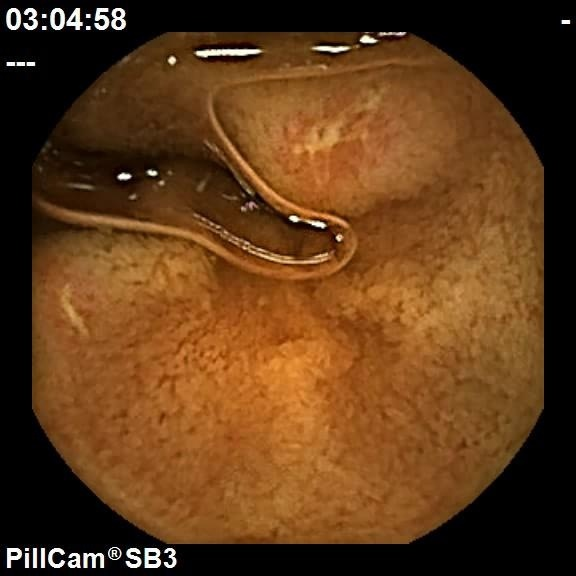

In [ ]:
from IPython.display import Image
Image(filename='/content/result_img/test_200436.jpg') 

In [ ]:
with open('/content/Lesions/annotations/instances_Images.json') as f:
  data = json.load(f)

In [ ]:
data

{'annotations': [{'area': 4121.7044221140695,
   'bbox': [168.10059171597635,
    289.9408284023669,
    63.90532544378698,
    64.49704142011831],
   'category_id': 4,
   'id': 0,
   'image_id': 149955,
   'iscrowd': 0},
  {'area': 9862.633758737655,
   'bbox': [194.77489177489178,
    301.7316017316017,
    102.16450216450215,
    96.53679653679654],
   'category_id': 1,
   'id': 1,
   'image_id': 122810,
   'iscrowd': 0},
  {'area': 9303.387674875707,
   'bbox': [110.84946236559139,
    189.32258064516128,
    82.79569892473117,
    112.36559139784947],
   'category_id': 3,
   'id': 2,
   'image_id': 140286,
   'iscrowd': 0},
  {'area': 31973.852040816324,
   'bbox': [69.47619047619048,
    292.8571428571429,
    198.21428571428572,
    161.3095238095238],
   'category_id': 1,
   'id': 3,
   'image_id': 137482,
   'iscrowd': 0},
  {'area': 23700.000000000004,
   'bbox': [294.66666666666663, 167.99999999999997, 158.0, 150.00000000000003],
   'category_id': 3,
   'id': 4,
   'image_id